### create array

In [1]:
import numpy as np
import pandas as pd

# Choose frequency, binsize, longitude, latitude
freq = 'D'
binsize = 2
longitude_W = 134  # minimum is 134
longitude_E = 174  # maximum is 174
latitude_S = 10  # minimum is 10
latitude_N = 60  # minimum is 60

# load earthquake data for defined area
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv', index_col=0)
data['Time'] = pd.to_datetime(data.Time)
data = data[(data.Longitude >= longitude_W) & (data.Longitude <= longitude_E) & (data.Latitude >= latitude_S) & (data.Latitude <= latitude_N)]
data.set_index('Time', inplace=True)
df = data.sort_index()

# Bin the longitude and latitude values into 2x2 degree bins
df['Longitude_bin'] = pd.cut(df['Longitude'], bins=np.arange(longitude_W, longitude_E + 1, binsize))  # Change bin size to 2 degrees
df['Latitude_bin'] = pd.cut(df['Latitude'], bins=np.arange(latitude_S, latitude_N + 1, binsize))  # Change bin size to 2 degrees

# Group the data by longitude bin, latitude bin, depth bin, and day, and compute the maximum magnitude within each group
grouped = df.groupby(['Longitude_bin', 'Latitude_bin', pd.Grouper(freq=freq, level="Time")]).agg({'Magnitude': 'max', 'Depth': 'mean'})
grouped = grouped.unstack().fillna(0)

# Reshape the resulting data into a tensor with shape (time, longitude, latitude, 4)
time = len(grouped.columns.levels[1])
longitude = len(grouped.index.levels[0])
latitude = len(grouped.index.levels[1])
tensor = np.zeros((time, longitude, latitude, 4))

for t in range(time):
    tensor[t, :, :, 0] = grouped['Magnitude'].iloc[:, t].values.reshape(longitude, latitude)
    tensor[t, :, :, 3] = grouped['Depth'].iloc[:, t].values.reshape(longitude, latitude)

latitude_values = np.linspace(latitude_S, latitude_N - binsize, latitude) + binsize / 2
longitude_values = np.linspace(longitude_W, longitude_E - binsize, longitude) + binsize / 2

tensor[:, :, :, 1] = np.repeat(latitude_values, longitude).reshape(latitude, longitude).T
tensor[:, :, :, 2] = np.tile(longitude_values, latitude).reshape(latitude, longitude).T

# Rotate dimensions corresponding to 20 and 25, 90 degrees anti-clockwise
tensor = np.transpose(tensor, axes=(0, 2, 1, 3))
tensor = np.flip(tensor, axis=1)

# Print the shape of the tensor
print(tensor.shape)

# Reshape tensor into matrix
matrix = np.reshape(tensor[:,:,:,0], (tensor.shape[0], -1))
# Keep only the columns with at least one number bigger than 0
matrix = matrix[:, (matrix > 0).sum(axis=0) >= 0]
print(matrix.shape)


(18260, 25, 20, 4)
(18260, 500)


### split the data

In [2]:
from sklearn.model_selection import train_test_split

# split data in train, val, test

# Activate when only forecasting one region
# matrix = np.reshape(matrix, (matrix.shape[0], matrix.shape[1], 1))

train, val_test = train_test_split(tensor, test_size=.3, shuffle=False, random_state=43)
val, test = train_test_split(val_test, test_size=.5, shuffle=False, random_state=43)

### create sliding window datasets

In [3]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

def dataset_generator(data, seq_length, samp_rate, stride, cutoff):

  input_data = data
  target_data = data
  dataset = timeseries_dataset_from_array(input_data, targets=None, sequence_length=seq_length, sampling_rate=samp_rate, sequence_stride=stride, shuffle=False, batch_size=len(data))

  return dataset

# Set lookback timewindow
lookback_window = 30 * 72
cutoff = 4.5
future_timesteps = 30
timewindow = lookback_window + future_timesteps
samp_rate = 1
stride = future_timesteps

train_dataset = dataset_generator(train, timewindow, samp_rate, stride, cutoff)
val_dataset = dataset_generator(val, timewindow, samp_rate, stride, cutoff)
test_dataset = dataset_generator(test, timewindow, samp_rate, stride, cutoff)

# Create train set
for batch in train_dataset:
    X_train = batch[:,:-future_timesteps,:,:]
    # X_train = np.reshape(X_train, (X_train.shape[0], -1))

    y_train = batch[:,-future_timesteps:,:,:,0] >= cutoff
    y_train = np.max(y_train, axis=1).astype(int)
    # y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1])).astype(int)

# y_train = tf.reshape(y_train, shape=[y_train.shape[0], 1, y_train.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_train = tf.cast(tf.reduce_max(y_train, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create validation set
for batch in val_dataset:
    X_val = batch[:,:-future_timesteps,:,:,:]
    # X_val = np.reshape(X_val, (X_val.shape[0], -1))

    y_val = batch[:,-future_timesteps:,:,:,0] >= cutoff
    y_val = np.max(y_val, axis=1).astype(int)
    # y_val = np.reshape(y_val, (y_val.shape[0], 1, y_val.shape[1])).astype(int)

# y_val = tf.reshape(y_val, shape=[y_val.shape[0], 1, y_val.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_val = tf.cast(tf.reduce_max(y_val, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create test set
for batch in test_dataset:
    X_test = batch[:,:-future_timesteps,:,:,:]
    # X_test = np.reshape(X_test, (X_test.shape[0], -1))

    y_test = batch[:,-future_timesteps:,:,:,0] >= cutoff
    y_test = np.max(y_test, axis=1).astype(int)
    # y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1])).astype(int)

# y_test = tf.reshape(y_test, shape=[y_test.shape[0], 1, y_test.shape[1]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
# y_test = tf.cast(tf.reduce_max(y_test, axis=2, keepdims=True) > 0, dtype=tf.int32)

################################# Use for MLP
# Flatten 1 and 2 dimensions of X's for multivariate MLP
# X_train = np.reshape(X_train, (X_train.shape[0],-1))
# X_val = np.reshape(X_val, (X_val.shape[0],-1))
# X_test = np.reshape(X_test, (X_test.shape[0],-1))

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

2023-04-09 17:46:14.604743: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(354, 2160, 25, 20, 4) (354, 25, 20)
(19, 2160, 25, 20, 4) (19, 25, 20)
(19, 2160, 25, 20, 4) (19, 25, 20)


### LSTM model build

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Dense, Flatten, Input, TimeDistributed, Dropout, RepeatVector, 
                                     BatchNormalization, Conv2D, MaxPooling2D, Reshape)
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import backend as K

keras.backend.clear_session()

# define model
model = Sequential()

# Add CNN layers
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=(X_train.shape[1:])))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(BatchNormalization())

# LSTM layers
model.add(LSTM(64, activation='tanh',
               return_sequences=True,
               kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
               bias_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),
               dropout=0.4,
               ))
               
model.add(BatchNormalization())

model.add(LSTM(64, activation='tanh', return_sequences=False))
model.add(BatchNormalization())

# Reshape to match the target shape
model.add(Dense(y_train.shape[1]*y_train.shape[2], activation="sigmoid"))
model.add(Reshape((y_train.shape[1], y_train.shape[2])))

opt = keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryFocalCrossentropy( apply_class_balancing=True, alpha=.7, gamma=1)
model.compile(optimizer=opt, loss=loss, metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

# Build and display the model summary
model.build(input_shape=X_train.shape)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (354, 2160, 25, 20, 4)   16        
 ormalization)                                                   
                                                                 
 time_distributed (TimeDistr  (354, 2160, 25, 20, 64)  2368      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (354, 2160, 12, 10, 64)  0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (354, 2160, 7680)        0         
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (354, 2160, 7680)        3

### fit model

In [5]:
# early stopping
callback = EarlyStopping(monitor='val_loss', patience=3)
# fit model
history = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val,y_val),
                    batch_size=128,
                    epochs=500,
                    verbose=1,
                    callbacks=[callback],
                    shuffle=False)

Epoch 1/500


: 

: 

### predict

In [63]:
y_pred = model.predict(X_val)

3/3 [==============================] - 0s 58ms/step


### evaluation metrics

In [64]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
# y_val = y_test
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.array(y_val).flatten(), y_pred.flatten() >= .5)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.array(y_val).flatten(), y_pred.flatten() >= .5)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.array(y_val).flatten(), y_pred.flatten() >= .5)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.array(y_val).flatten(), y_pred.flatten() >= .5)
print('F1 score: %f' % f1)

class_names = ['M<4.5', 'M>=4.5']

print(classification_report(np.array(y_val).flatten(), y_pred.flatten() >= .5, target_names=class_names))

# Calculate the proportion of the majority per row, column combination over all batches
majority_prop = np.mean(val[:,:,:,0] >= cutoff, axis=0)[:]

# Calculate the complement for values lower than 0.5
majority_prop = np.where(majority_prop < 0.5, 1 - majority_prop, majority_prop)
zeroR = majority_prop.mean()

print("zeroR:", round(zeroR,4))

Accuracy: 0.914265
Precision: 0.761029
Recall: 0.865505
F1 score: 0.809912
              precision    recall  f1-score   support

       M<4.5       0.96      0.93      0.94      5365
      M>=4.5       0.76      0.87      0.81      1435

    accuracy                           0.91      6800
   macro avg       0.86      0.90      0.88      6800
weighted avg       0.92      0.91      0.92      6800

zeroR: 0.9775


### confusion matrix

[Text(0, 0.5, 'M<4.5'), Text(0, 1.5, 'M>=4.5')]

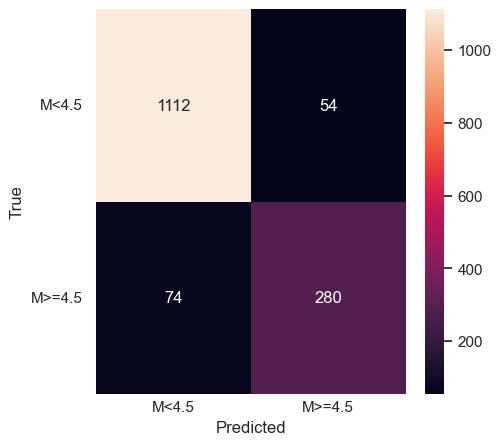

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(rc={'figure.figsize':(5,5)})
p = sns.heatmap(confusion_matrix(np.array(y_val).flatten(), y_pred.flatten() >= 0.5), annot=True, fmt='g')
p.set_xlabel("Predicted")
p.set_ylabel("True")
p.xaxis.set_ticklabels(['M<4.5', 'M>=4.5'], ha="center", va="center")
p.yaxis.set_ticklabels(['M<4.5', 'M>=4.5'], rotation=0, va="center")

### ROC curve

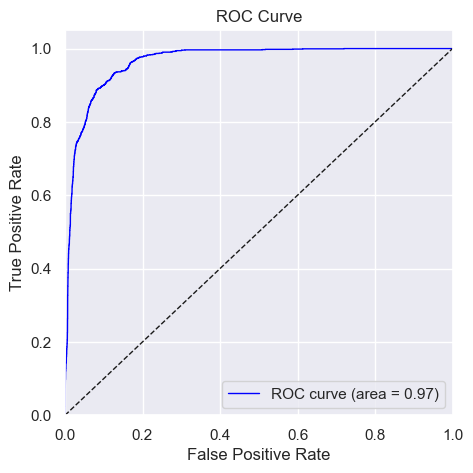

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# y_pred = scaler.inverse_transform(y_prob)
# y_test = scaler.inverse_transform(y)

# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(np.array(y_val).flatten(), y_pred.flatten())
roc_auc = auc(fpr, tpr)

# Plot micro-average ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
        ''.format(roc_auc), color='blue', linewidth=1)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
# plt.savefig(savefig)
plt.show()

### PR curve

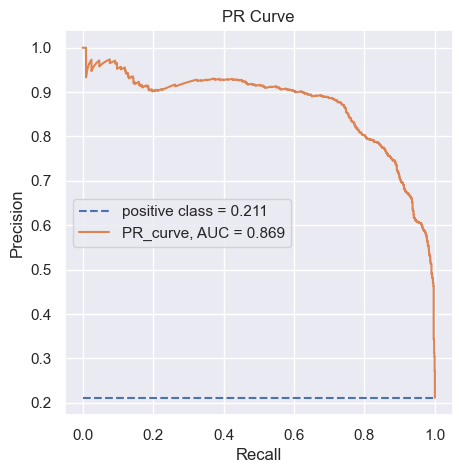

In [66]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, f1_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(np.array(y_val).flatten(), y_pred.flatten())
auc = auc(recall, precision)

# Calculate the proportion of the majority per row, column combination over all batches
majority_prop = np.mean(test >= cutoff, axis=0)[:]

# Calculate the complement for values lower than 0.5
majority_prop = np.where(majority_prop < 0.5, 1 - majority_prop, majority_prop)
zeroR = majority_prop.mean()

# plot the precision-recall curves
no_skill = (np.array(y_val).flatten()).sum() / len(np.array(y_val).flatten())
plt.plot([0, 1], [no_skill,no_skill], linestyle='--', label='positive class = %.3f' % (no_skill))
plt.plot(recall, precision, label='PR_curve, AUC = %.3f' % (auc))
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

### plot predicted against true

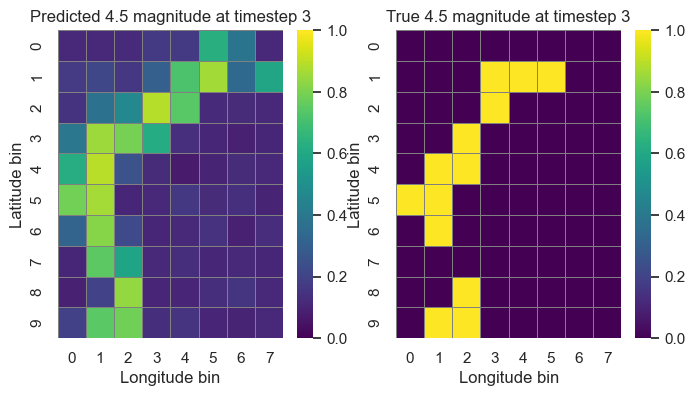

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape data to grid
y_pred = np.reshape(y_pred, (y_pred.shape[0], tensor.shape[1], tensor.shape[2]))
true = np.reshape(y_val, (y_val.shape[0], tensor.shape[1], tensor.shape[2]))

# Choose timesteps to plot
timestep = 3


# Extract the data for the chosen timesteps from the tensor
data1 = y_pred[timestep, :, :] 
data2 = true[timestep, :, :]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

# Plot the data in each subplot
sns.heatmap(data1, cmap='viridis', vmin=0, vmax=1, linewidths=0.5, linecolor='grey', annot=False, ax=ax1)
sns.heatmap(data2, cmap='viridis', vmin=0, vmax=1, linewidths=0.5, linecolor='grey', annot=False, ax=ax2)

# Set the plot titles and axis labels
ax1.set_title(f'Predicted {cutoff} magnitude at timestep {timestep}')
ax1.set_xlabel('Longitude bin')
ax1.set_ylabel('Latitude bin')

ax2.set_title(f'True {cutoff} magnitude at timestep {timestep}')
ax2.set_xlabel('Longitude bin')
ax2.set_ylabel('Latitude bin')

# Show the plot
plt.show()